In [1]:
!pip install torch torchvision torchaudio
!pip install nibabel matplotlib tqdm opencv-python scikit-learn
!pip install scipy pillow pandas

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" (from torch) (from versions: none)
ERROR: No matching distribution found for nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install matplotlib==3.7.2, nibabel==5.3.2 and opencv-python==4.12.0.88 because these package versions have conflicting dependencies.

The conflict is caused by:
    nibabel 5.3.2 depends on numpy>=1.22
    matplotlib 3.7.2 depends on numpy>=1.20
    opencv-python 4.12.0.88 depends on numpy<2.3.0 and >=2; python_version >= "3.9"

To fix this you could try to:
1. lo

In [1]:
# Проверяем установку
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import os

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
# Создаем папки для организации
folders = [
    'data/processed/train/images',
    'data/processed/train/masks', 
    'data/processed/val/images',
    'data/processed/val/masks',
    'data/processed/test/images',
    'data/processed/test/masks',
    'models',
    'results'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"Создана папка: {folder}")

Создана папка: data/processed/train/images
Создана папка: data/processed/train/masks
Создана папка: data/processed/val/images
Создана папка: data/processed/val/masks
Создана папка: data/processed/test/images
Создана папка: data/processed/test/masks
Создана папка: models
Создана папка: results


In [3]:
# 🔥 ВАШ ПЕРВЫЙ БЛОК КОДА - собираем файлы
print("📁 Собираем информацию о файлах...")

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

# 🔥 ВАШ ВТОРОЙ БЛОК КОДА - создаем соответствия
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

print(f"✅ Найдено {len(df_files)} пар КТ-маска")
print("\nПервые 5 записей:")
print(df_files.head())

# Проверяем данные
print(f"\n📊 Информация о данных:")
print(f"Всего пациентов: {len(df_files)}")
print(f"КТ файлы: {df_files['filename'].tolist()[:5]}...")
print(f"Маски: {df_files['mask_filename'].tolist()[:5]}...")

📁 Собираем информацию о файлах...
✅ Найдено 131 пар КТ-маска

Первые 5 записей:
                                             dirname        filename  \
0       ../input/liver-tumor-segmentation/volume_pt1    volume-0.nii   
1       ../input/liver-tumor-segmentation/volume_pt1    volume-1.nii   
2       ../input/liver-tumor-segmentation/volume_pt1   volume-10.nii   
3  ../input/liver-tumor-segmentation-part-2/volum...  volume-100.nii   
4  ../input/liver-tumor-segmentation-part-2/volum...  volume-101.nii   

                                      mask_dirname         mask_filename  
0  ../input/liver-tumor-segmentation/segmentations    segmentation-0.nii  
1  ../input/liver-tumor-segmentation/segmentations    segmentation-1.nii  
2  ../input/liver-tumor-segmentation/segmentations   segmentation-10.nii  
3  ../input/liver-tumor-segmentation/segmentations  segmentation-100.nii  
4  ../input/liver-tumor-segmentation/segmentations  segmentation-101.nii  

📊 Информация о данных:
Всего пациент

In [4]:
from tqdm import tqdm
import cv2
def read_nii(filepath):
    """Загружаем .nii файл"""
    try:
        ct_scan = nib.load(filepath)
        return ct_scan.get_fdata()
    except Exception as e:
        print(f"Ошибка загрузки {filepath}: {e}")
        return None

def apply_liver_window(ct_slice):
    """Применяем liver window к КТ срезу"""
    width = 150
    level = 30
    
    window_min = level - width // 2  # -45 HU
    window_max = level + width // 2  # 105 HU
    
    ct_slice = np.clip(ct_slice, window_min, window_max)
    ct_slice = (ct_slice - window_min) / (window_max - window_min)
    ct_slice = np.clip(ct_slice, 0, 1)
    
    return ct_slice

def preprocess_patient(patient_idx, df, output_dir, split_name):
    """Обрабатываем одного пациента"""
    try:
        # Загружаем КТ и маску
        ct_path = df.loc[patient_idx, 'dirname'] + "/" + df.loc[patient_idx, 'filename']
        mask_path = df.loc[patient_idx, 'mask_dirname'] + "/" + df.loc[patient_idx, 'mask_filename']
        
        ct_volume = read_nii(ct_path)
        mask_volume = read_nii(mask_path)
        
        if ct_volume is None or mask_volume is None:
            return 0
        
        processed_slices = 0
        
        # Обрабатываем каждый срез
        for slice_idx in range(ct_volume.shape[2]):
            ct_slice = ct_volume[:, :, slice_idx]
            mask_slice = mask_volume[:, :, slice_idx]
            
            # Пропускаем срезы без печени
            if np.sum(mask_slice) < 50:
                continue
                
            # Препроцессинг
            ct_slice = apply_liver_window(ct_slice)
            mask_slice = (mask_slice > 0).astype(np.uint8)  # бинаризуем
            
            # Ресайз до 256x256
            ct_slice = cv2.resize(ct_slice, (256, 256))
            mask_slice = cv2.resize(mask_slice, (256, 256))
            
            # Сохраняем
            filename = f"patient_{patient_idx:03d}_slice_{slice_idx:03d}"
            np.save(f"{output_dir}/{split_name}/images/{filename}.npy", ct_slice)
            np.save(f"{output_dir}/{split_name}/masks/{filename}.npy", mask_slice)
            
            processed_slices += 1
            
        return processed_slices
        
    except Exception as e:
        print(f"Ошибка обработки пациента {patient_idx}: {e}")
        return 0

# Разделяем данные на train/val/test
print("🔄 Разделяем данные на train/val/test...")

np.random.seed(42)
all_indices = np.arange(len(df_files))
np.random.shuffle(all_indices)

n_train = int(0.7 * len(df_files))
n_val = int(0.15 * len(df_files))

train_indices = all_indices[:n_train]
val_indices = all_indices[n_train:n_train + n_val]
test_indices = all_indices[n_train + n_val:]

print(f"Train: {len(train_indices)} пациентов")
print(f"Val: {len(val_indices)} пациентов")
print(f"Test: {len(test_indices)} пациентов")

# Обрабатываем и сохраняем данные
print("🔄 Начинаем препроцессинг...")

total_slices = 0

for idx in tqdm(train_indices, desc="Train patients"):
    total_slices += preprocess_patient(idx, df_files, 'data/processed', 'train')

for idx in tqdm(val_indices, desc="Val patients"):
    total_slices += preprocess_patient(idx, df_files, 'data/processed', 'val')

for idx in tqdm(test_indices, desc="Test patients"):
    total_slices += preprocess_patient(idx, df_files, 'data/processed', 'test')

print(f"✅ Препроцессинг завершен! Обработано срезов: {total_slices}")

# Сохраняем информацию о разделении
split_info = {
    'train_indices': train_indices.tolist(),
    'val_indices': val_indices.tolist(),
    'test_indices': test_indices.tolist(),
    'total_slices': total_slices
}

import json
with open('data/processed/split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

🔄 Разделяем данные на train/val/test...
Train: 91 пациентов
Val: 19 пациентов
Test: 21 пациентов
🔄 Начинаем препроцессинг...


Test patients: 100%|██████████| 21/21 [01:53<00:00,  5.42s/it]

✅ Препроцессинг завершен! Обработано срезов: 19094


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class LiverDataset(Dataset):
    def __init__(self, data_dir, transform=False):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(data_dir + '/images') if f.endswith('.npy')])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Загружаем изображение и маску
        image_path = os.path.join(self.data_dir, 'images', self.image_files[idx])
        mask_path = os.path.join(self.data_dir, 'masks', self.image_files[idx])
        
        image = np.load(image_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)
        
        # Добавляем размерность канала
        image = np.expand_dims(image, axis=0)  # [1, H, W]
        mask = np.expand_dims(mask, axis=0)    # [1, H, W]
        
        # Аугментации 🎯
        if self.transform:
            image, mask = self.apply_augmentations(image, mask)
        
        return (
            torch.FloatTensor(image),  # [1, 256, 256]
            torch.FloatTensor(mask)    # [1, 256, 256]
        )
    
    def apply_augmentations(self, image, mask):
        """Применяем аугментации: сдвиги, повороты, масштабирование"""
        # СДВИГИ (40% вероятность)
        if random.random() < 0.4:
            max_shift = int(256 * 0.1)  # 10% от размера
            shift_x = random.randint(-max_shift, max_shift)
            shift_y = random.randint(-max_shift, max_shift)
            
            # Сдвигаем изображение и маску одинаково
            image = self.shift_image(image, shift_x, shift_y)
            mask = self.shift_image(mask, shift_x, shift_y)
        
        # ПОВОРОТЫ (50% вероятность)
        if random.random() < 0.5:
            angle = random.uniform(-15, 15)  # ±15 градусов
            image = self.rotate_image(image, angle)
            mask = self.rotate_image(mask, angle)
        
        # МАСШТАБИРОВАНИЕ (30% вероятность)
        if random.random() < 0.3:
            scale = random.uniform(0.9, 1.1)  # 90%-110%
            image = self.scale_image(image, scale)
            mask = self.scale_image(mask, scale)
        
        return image, mask
    
    def shift_image(self, img, shift_x, shift_y):
        """Сдвиг изображения"""
        # Простая реализация сдвига
        if shift_x == 0 and shift_y == 0:
            return img
        
        result = np.zeros_like(img)
        h, w = img.shape[1], img.shape[2]
        
        # Вычисляем новые координаты
        x_start = max(0, shift_x)
        x_end = min(w, w + shift_x)
        y_start = max(0, shift_y)
        y_end = min(h, h + shift_y)
        
        # Старые координаты
        old_x_start = max(0, -shift_x)
        old_x_end = min(w, w - shift_x)
        old_y_start = max(0, -shift_y)
        old_y_end = min(h, h - shift_y)
        
        result[:, y_start:y_end, x_start:x_end] = img[:, old_y_start:old_y_end, old_x_start:old_x_end]
        return result
    
    def rotate_image(self, img, angle):
        """Поворот изображения"""
        from scipy import ndimage
        # Поворачиваем каждый канал
        rotated = ndimage.rotate(img[0], angle, reshape=False, order=1, mode='constant')
        return np.expand_dims(rotated, axis=0)
    
    def scale_image(self, img, scale):
        from skimage.transform import resize
        h, w = img.shape[1], img.shape[2]
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Масштабируем каждый канал отдельно
        scaled_channels = []
        for channel in range(img.shape[0]):
            channel_data = img[channel]  # [H, W]
            scaled_channel = resize(channel_data, (new_h, new_w), order=1, mode='constant', preserve_range=True)
            scaled_channels.append(scaled_channel)
        
        # Собираем обратно
        scaled = np.stack(scaled_channels, axis=0)  # [C, H, W]
        
        # Если размер уменьшился - дополняем нулями
        if new_h < h or new_w < w:
            result = np.zeros_like(img)
            start_h = (h - new_h) // 2
            start_w = (w - new_w) // 2
            result[:, start_h:start_h+new_h, start_w:start_w+new_w] = scaled
            return result
        # Если размер увеличился - обрезаем
        else:
            start_h = (new_h - h) // 2
            start_w = (new_w - w) // 2
            return scaled[:, start_h:start_h+h, start_w:start_w+w]

# Создаем датасеты
import numpy as np

class SmallLiverDataset(Dataset):
    def __init__(self, original_dataset, fraction=0.3):  # 30% данных
        self.original_dataset = original_dataset
        self.indices = np.random.choice(
            len(original_dataset), 
            int(len(original_dataset) * fraction), 
            replace=False
        )
        print(f"Создан уменьшенный датасет: {len(self.indices)} срезов ({fraction*100}% от оригинальных {len(original_dataset)})")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.original_dataset[self.indices[idx]]

# СОЗДАЕМ УМЕНЬШЕННЫЕ ДАТАСЕТЫ (30% данных)
print("🔄 Создаем оптимизированные датасеты...")

# Сначала создаем обычные датасеты
train_dataset_full = LiverDataset('data/processed/train', transform=True)
val_dataset_full = LiverDataset('data/processed/val', transform=False)  
test_dataset_full = LiverDataset('data/processed/test', transform=False)

# Затем уменьшаем их до 30%
train_dataset = SmallLiverDataset(train_dataset_full, fraction=0.3)
val_dataset = SmallLiverDataset(val_dataset_full, fraction=0.3)
test_dataset = test_dataset_full  # тест оставляем полным

# СОЗДАЕМ ДАТАЛОАДЕРЫ С БОЛЬШИМ BATCH SIZE
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # batch_size=32 ✅
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

print(f"✅ Оптимизированные датасеты созданы!")
print(f"   Train: {len(train_dataset)} срезов (было {len(train_dataset_full)})")
print(f"   Val: {len(val_dataset)} срезов (было {len(val_dataset_full)})")
print(f"   Test: {len(test_dataset)} срезов")
print(f"   Batch size: 32 (увеличено в 4 раза)")
print(f"   Train: {len(train_dataset)} срезов")
print(f"   Val: {len(val_dataset)} срезов")
print(f"   Test: {len(test_dataset)} срезов")

🔄 Создаем оптимизированные датасеты...
Создан уменьшенный датасет: 4176 срезов (30.0% от оригинальных 13920)
Создан уменьшенный датасет: 686 срезов (30.0% от оригинальных 2289)
✅ Оптимизированные датасеты созданы!
   Train: 4176 срезов (было 13920)
   Val: 686 срезов (было 2289)
   Test: 2885 срезов
   Batch size: 32 (увеличено в 4 раза)
   Train: 4176 срезов
   Val: 686 срезов
   Test: 2885 срезов


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class UNet2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet2D, self).__init__()
        
        # Encoder (Down path)
        self.encoder1 = self._block(in_channels, features[0])
        self.encoder2 = self._block(features[0], features[1])
        self.encoder3 = self._block(features[1], features[2])
        self.encoder4 = self._block(features[2], features[3])
        
        # Bottleneck
        self.bottleneck = self._block(features[3], features[3] * 2)
        
        # Decoder (Up path)
        self.decoder1 = self._block(features[3] * 2 + features[3], features[3])
        self.decoder2 = self._block(features[3] + features[2], features[2])
        self.decoder3 = self._block(features[2] + features[1], features[1])
        self.decoder4 = self._block(features[1] + features[0], features[0])
        
        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Pooling & Upsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)        # [B, 64, 256, 256]
        e2 = self.encoder2(self.pool(e1))  # [B, 128, 128, 128]
        e3 = self.encoder3(self.pool(e2))  # [B, 256, 64, 64]
        e4 = self.encoder4(self.pool(e3))  # [B, 512, 32, 32]
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(e4))  # [B, 1024, 16, 16]
        
        # Decoder with skip connections
        d1 = self.upsample(bottleneck)               # [B, 1024, 32, 32]
        d1 = torch.cat([d1, e4], dim=1)              # [B, 1536, 32, 32]
        d1 = self.decoder1(d1)                       # [B, 512, 32, 32]
        
        d2 = self.upsample(d1)                       # [B, 512, 64, 64]
        d2 = torch.cat([d2, e3], dim=1)              # [B, 768, 64, 64]
        d2 = self.decoder2(d2)                       # [B, 256, 64, 64]
        
        d3 = self.upsample(d2)                       # [B, 256, 128, 128]
        d3 = torch.cat([d3, e2], dim=1)              # [B, 384, 128, 128]
        d3 = self.decoder3(d3)                       # [B, 128, 128, 128]
        
        d4 = self.upsample(d3)                       # [B, 128, 256, 256]
        d4 = torch.cat([d4, e1], dim=1)              # [B, 192, 256, 256]
        d4 = self.decoder4(d4)                       # [B, 64, 256, 256]
        
        output = self.final_conv(d4)                 # [B, 1, 256, 256]
        
        return output

# Loss Functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (
            pred_flat.sum() + target_flat.sum() + self.smooth
        )
        
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        p_t = pred * target + (1 - pred) * (1 - target)
        focal_term = (1 - p_t) ** self.gamma
        alpha_term = self.alpha * target + (1 - self.alpha) * (1 - target)
        
        focal_loss = alpha_term * focal_term * bce
        return focal_loss.mean()

class CombinedLoss(nn.Module):
    """60% Dice + 40% Focal Loss"""
    def __init__(self, dice_weight=0.6, focal_weight=0.4):
        super().__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()
        
    def forward(self, pred, target):
        dice_loss = self.dice_loss(pred, target)
        focal_loss = self.focal_loss(pred, target)
        
        total_loss = (
            self.dice_weight * dice_loss + 
            self.focal_weight * focal_loss
        )
        return total_loss

# Метрики
class DiceScore(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = (torch.sigmoid(pred) > 0.5).float()
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (
            pred.sum() + target.sum() + self.smooth
        )
        return dice

class IoUScore(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = (torch.sigmoid(pred) > 0.5).float()
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        return iou

# Создаем модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Используется устройство: {device}")

model = UNet2D(in_channels=1, out_channels=1).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Модель создана! Параметров: {total_params:,}")

🖥️ Используется устройство: cuda
✅ Модель создана! Параметров: 31,383,681


In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# ⚙️ КОНФИГУРАЦИЯ ОБУЧЕНИЯ
EPOCHS = 30
PATIENCE = 10
MIN_DELTA = 0.002

# Optimizer: AdamW с learning rate 1e-4
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,           # ⭐ LEARNING RATE = 0.0001
    weight_decay=0.01
)

# Scheduler: CosineAnnealingLR
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,      # ⭐ 50 эпох
    eta_min=1e-6
)

# Loss: 60% Dice + 40% Focal ⭐
criterion = CombinedLoss(dice_weight=0.6, focal_weight=0.4)

# Метрики
dice_metric = DiceScore()
iou_metric = IoUScore()

print("✅ Оптимизатор настроен!")
print(f"   Optimizer: AdamW, LR=1e-4")
print(f"   Scheduler: CosineAnnealingLR")
print(f"   Loss: 0.6 * Dice + 0.4 * Focal")
print(f"   Early Stopping: {PATIENCE} эпох")

# Функции для обучения
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for batch_idx, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice_score = dice_metric(outputs, masks)
            iou_score = iou_metric(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice_score.item()
        running_iou += iou_score.item()
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Dice': f'{dice_score.item():.4f}'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            dice_score = dice_metric(outputs, masks)
            iou_score = iou_metric(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice_score.item()
            running_iou += iou_score.item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    
    return epoch_loss, epoch_dice, epoch_iou

def save_checkpoint(model, optimizer, epoch, metrics, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': metrics['train_loss'],
        'val_dice': metrics['val_dice'],
        'val_iou': metrics['val_iou']
    }
    torch.save(checkpoint, filename)
    print(f"💾 Чекпоинт сохранен: {filename}")

✅ Оптимизатор настроен!
   Optimizer: AdamW, LR=1e-4
   Scheduler: CosineAnnealingLR
   Loss: 0.6 * Dice + 0.4 * Focal
   Early Stopping: 10 эпох


In [8]:
# История обучения
history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [], 
    'train_iou': [], 'val_iou': [],
    'learning_rates': []
}

best_dice = 0.0
early_stop_counter = 0

print("🚀 Начинаем обучение!")
print(f"Эпохи: {EPOCHS}, Early Stopping: {PATIENCE}, Min Delta: {MIN_DELTA}")

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"ЭПОХА {epoch+1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Обучение
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, optimizer, criterion, device
    )
    
    # Валидация
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Обновляем scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Сохраняем историю
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['learning_rates'].append(current_lr)
    
    # Выводим результаты
    print(f"\n📊 Результаты эпохи {epoch+1}:")
    print(f"   Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"   Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
    print(f"   LR: {current_lr:.2e}")
    
    # Early Stopping
    if val_dice > best_dice + MIN_DELTA:
        best_dice = val_dice
        early_stop_counter = 0
        
        save_checkpoint(model, optimizer, epoch, {
            'train_loss': train_loss,
            'val_dice': val_dice,
            'val_iou': val_iou
        }, 'models/best_model.pth')
        
        print(f"🎉 Новый рекорд! Dice: {val_dice:.4f}")
    else:
        early_stop_counter += 1
        print(f"⏳ Early stopping counter: {early_stop_counter}/{PATIENCE}")
    
    # Проверяем early stopping
    if early_stop_counter >= PATIENCE:
        print(f"🛑 Early stopping на эпохе {epoch+1}!")
        break

print(f"\n✅ Обучение завершено! Лучший Dice: {best_dice:.4f}")
torch.save(model.state_dict(), 'models/final_model.pth')

🚀 Начинаем обучение!
Эпохи: 30, Early Stopping: 10, Min Delta: 0.002

ЭПОХА 1/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 1:
   Train - Loss: 0.4128, Dice: 0.8105, IoU: 0.6966
   Val   - Loss: 0.3980, Dice: 0.8884, IoU: 0.8000
   LR: 9.97e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.8884

ЭПОХА 2/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 2:
   Train - Loss: 0.3688, Dice: 0.9030, IoU: 0.8244
   Val   - Loss: 0.3659, Dice: 0.9221, IoU: 0.8561
   LR: 9.89e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9221

ЭПОХА 3/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 3:
   Train - Loss: 0.3302, Dice: 0.9234, IoU: 0.8582
   Val   - Loss: 0.3153, Dice: 0.9232, IoU: 0.8579
   LR: 9.76e-05
⏳ Early stopping counter: 1/10

ЭПОХА 4/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 4:
   Train - Loss: 0.2870, Dice: 0.9361, IoU: 0.8804
   Val   - Loss: 0.2791, Dice: 0.9176, IoU: 0.8482
   LR: 9.57e-05
⏳ Early stopping counter: 2/10

ЭПОХА 5/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 5:
   Train - Loss: 0.2451, Dice: 0.9435, IoU: 0.8934
   Val   - Loss: 0.2867, Dice: 0.7626, IoU: 0.6175
   LR: 9.34e-05
⏳ Early stopping counter: 3/10

ЭПОХА 6/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 6:
   Train - Loss: 0.2035, Dice: 0.9522, IoU: 0.9088
   Val   - Loss: 0.2203, Dice: 0.9122, IoU: 0.8400
   LR: 9.05e-05
⏳ Early stopping counter: 4/10

ЭПОХА 7/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 7:
   Train - Loss: 0.1683, Dice: 0.9555, IoU: 0.9149
   Val   - Loss: 0.1708, Dice: 0.9406, IoU: 0.8882
   LR: 8.73e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9406

ЭПОХА 8/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 8:
   Train - Loss: 0.1392, Dice: 0.9615, IoU: 0.9259
   Val   - Loss: 0.1428, Dice: 0.9449, IoU: 0.8959
   LR: 8.36e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9449

ЭПОХА 9/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 9:
   Train - Loss: 0.1162, Dice: 0.9658, IoU: 0.9339
   Val   - Loss: 0.1271, Dice: 0.9366, IoU: 0.8812
   LR: 7.96e-05
⏳ Early stopping counter: 1/10

ЭПОХА 10/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 10:
   Train - Loss: 0.0992, Dice: 0.9675, IoU: 0.9370
   Val   - Loss: 0.1050, Dice: 0.9519, IoU: 0.9085
   LR: 7.52e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9519

ЭПОХА 11/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 11:
   Train - Loss: 0.0849, Dice: 0.9703, IoU: 0.9423
   Val   - Loss: 0.0922, Dice: 0.9546, IoU: 0.9134
   LR: 7.06e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9546

ЭПОХА 12/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 12:
   Train - Loss: 0.0763, Dice: 0.9689, IoU: 0.9397
   Val   - Loss: 0.0919, Dice: 0.9412, IoU: 0.8896
   LR: 6.58e-05
⏳ Early stopping counter: 1/10

ЭПОХА 13/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 13:
   Train - Loss: 0.0673, Dice: 0.9714, IoU: 0.9444
   Val   - Loss: 0.0829, Dice: 0.9503, IoU: 0.9058
   LR: 6.08e-05
⏳ Early stopping counter: 2/10

ЭПОХА 14/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 14:
   Train - Loss: 0.0604, Dice: 0.9734, IoU: 0.9481
   Val   - Loss: 0.0734, Dice: 0.9566, IoU: 0.9171
   LR: 5.57e-05
💾 Чекпоинт сохранен: models/best_model.pth
🎉 Новый рекорд! Dice: 0.9566

ЭПОХА 15/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 15:
   Train - Loss: 0.0558, Dice: 0.9731, IoU: 0.9477
   Val   - Loss: 0.0708, Dice: 0.9510, IoU: 0.9070
   LR: 5.05e-05
⏳ Early stopping counter: 1/10

ЭПОХА 16/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.73it/s]



📊 Результаты эпохи 16:
   Train - Loss: 0.0507, Dice: 0.9751, IoU: 0.9515
   Val   - Loss: 0.0659, Dice: 0.9539, IoU: 0.9122
   LR: 4.53e-05
⏳ Early stopping counter: 2/10

ЭПОХА 17/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 17:
   Train - Loss: 0.0471, Dice: 0.9761, IoU: 0.9534
   Val   - Loss: 0.0626, Dice: 0.9560, IoU: 0.9161
   LR: 4.02e-05
⏳ Early stopping counter: 3/10

ЭПОХА 18/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 18:
   Train - Loss: 0.0441, Dice: 0.9768, IoU: 0.9548
   Val   - Loss: 0.0600, Dice: 0.9556, IoU: 0.9153
   LR: 3.52e-05
⏳ Early stopping counter: 4/10

ЭПОХА 19/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.72it/s]



📊 Результаты эпохи 19:
   Train - Loss: 0.0420, Dice: 0.9774, IoU: 0.9557
   Val   - Loss: 0.0562, Dice: 0.9576, IoU: 0.9188
   LR: 3.04e-05
⏳ Early stopping counter: 5/10

ЭПОХА 20/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 20:
   Train - Loss: 0.0399, Dice: 0.9778, IoU: 0.9566
   Val   - Loss: 0.0557, Dice: 0.9577, IoU: 0.9190
   LR: 2.58e-05
⏳ Early stopping counter: 6/10

ЭПОХА 21/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 21:
   Train - Loss: 0.0381, Dice: 0.9785, IoU: 0.9580
   Val   - Loss: 0.0551, Dice: 0.9574, IoU: 0.9186
   LR: 2.14e-05
⏳ Early stopping counter: 7/10

ЭПОХА 22/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 22:
   Train - Loss: 0.0368, Dice: 0.9790, IoU: 0.9588
   Val   - Loss: 0.0527, Dice: 0.9581, IoU: 0.9197
   LR: 1.74e-05
⏳ Early stopping counter: 8/10

ЭПОХА 23/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 23:
   Train - Loss: 0.0359, Dice: 0.9792, IoU: 0.9592
   Val   - Loss: 0.0545, Dice: 0.9550, IoU: 0.9141
   LR: 1.37e-05
⏳ Early stopping counter: 9/10

ЭПОХА 24/30


Validation: 100%|██████████| 22/22 [00:12<00:00,  1.71it/s]



📊 Результаты эпохи 24:
   Train - Loss: 0.0347, Dice: 0.9797, IoU: 0.9602
   Val   - Loss: 0.0526, Dice: 0.9569, IoU: 0.9177
   LR: 1.05e-05
⏳ Early stopping counter: 10/10
🛑 Early stopping на эпохе 24!

✅ Обучение завершено! Лучший Dice: 0.9566


In [9]:
def test_model(model, test_loader, device):
    """Тестируем модель на тестовом наборе"""
    model.eval()
    
    test_dice = 0.0
    test_iou = 0.0
    test_precision = 0.0
    test_recall = 0.0
    
    print("🧪 Начинаем тестирование на тестовом наборе...")
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            pred_masks = torch.sigmoid(outputs)
            
            # Бинаризуем предсказания
            pred_binary = (pred_masks > 0.5).float()
            
            # Вычисляем метрики
            dice = dice_metric(outputs, masks)
            iou = iou_metric(outputs, masks)
            
            # Precision и Recall
            true_positives = (pred_binary * masks).sum()
            false_positives = (pred_binary * (1 - masks)).sum()
            false_negatives = ((1 - pred_binary) * masks).sum()
            
            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            
            test_dice += dice.item()
            test_iou += iou.item()
            test_precision += precision.item()
            test_recall += recall.item()
            
            # Сохраняем для визуализации
            if len(all_predictions) < 10:
                all_predictions.append(pred_binary.cpu().numpy())
                all_targets.append(masks.cpu().numpy())
    
    # Средние метрики
    num_batches = len(test_loader)
    avg_dice = test_dice / num_batches
    avg_iou = test_iou / num_batches
    avg_precision = test_precision / num_batches
    avg_recall = test_recall / num_batches
    
    print(f"\n📊 ТЕСТОВЫЕ МЕТРИКИ:")
    print(f"   Dice:      {avg_dice:.4f}")
    print(f"   IoU:       {avg_iou:.4f}")
    print(f"   Precision: {avg_precision:.4f}")
    print(f"   Recall:    {avg_recall:.4f}")
    print(f"   F1-Score:  {2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-6):.4f}")
    
    return avg_dice, avg_iou, all_predictions, all_targets

# Загружаем лучшую модель и тестируем
print("Загружаем лучшую модель для тестирования...")

best_model = UNet2D(in_channels=1, out_channels=1).to(device)
checkpoint = torch.load('models/best_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

# Тестируем
test_dice, test_iou, test_predictions, test_targets = test_model(
    best_model, test_loader, device
)

# Сохраняем результаты тестирования
test_results = {
    'test_dice': test_dice,
    'test_iou': test_iou,
    'num_test_samples': len(test_loader.dataset),
    'model_parameters': sum(p.numel() for p in best_model.parameters())
}

with open('results/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"✅ Результаты тестирования сохранены!")

Загружаем лучшую модель для тестирования...
🧪 Начинаем тестирование на тестовом наборе...


Testing: 100%|██████████| 2885/2885 [01:16<00:00, 37.72it/s]


📊 ТЕСТОВЫЕ МЕТРИКИ:
   Dice:      0.9149
   IoU:       0.8757
   Precision: 0.9239
   Recall:    0.9185
   F1-Score:  0.9212
✅ Результаты тестирования сохранены!


Создаем визуализации...


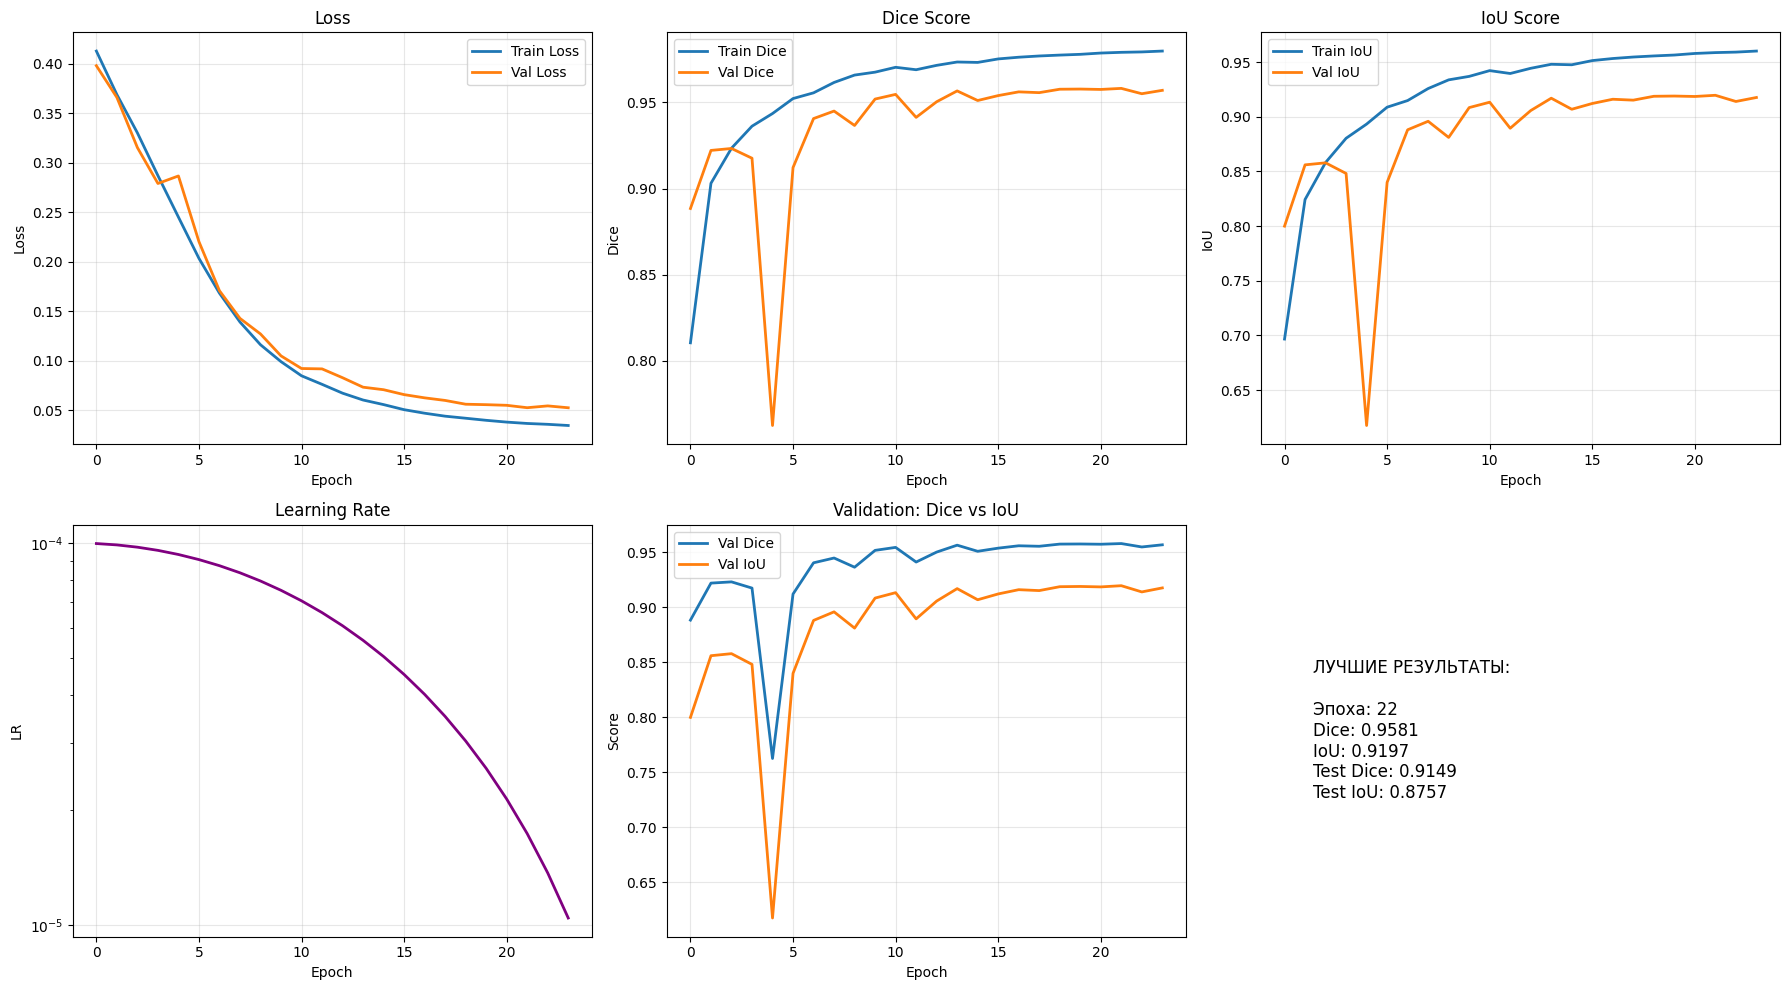

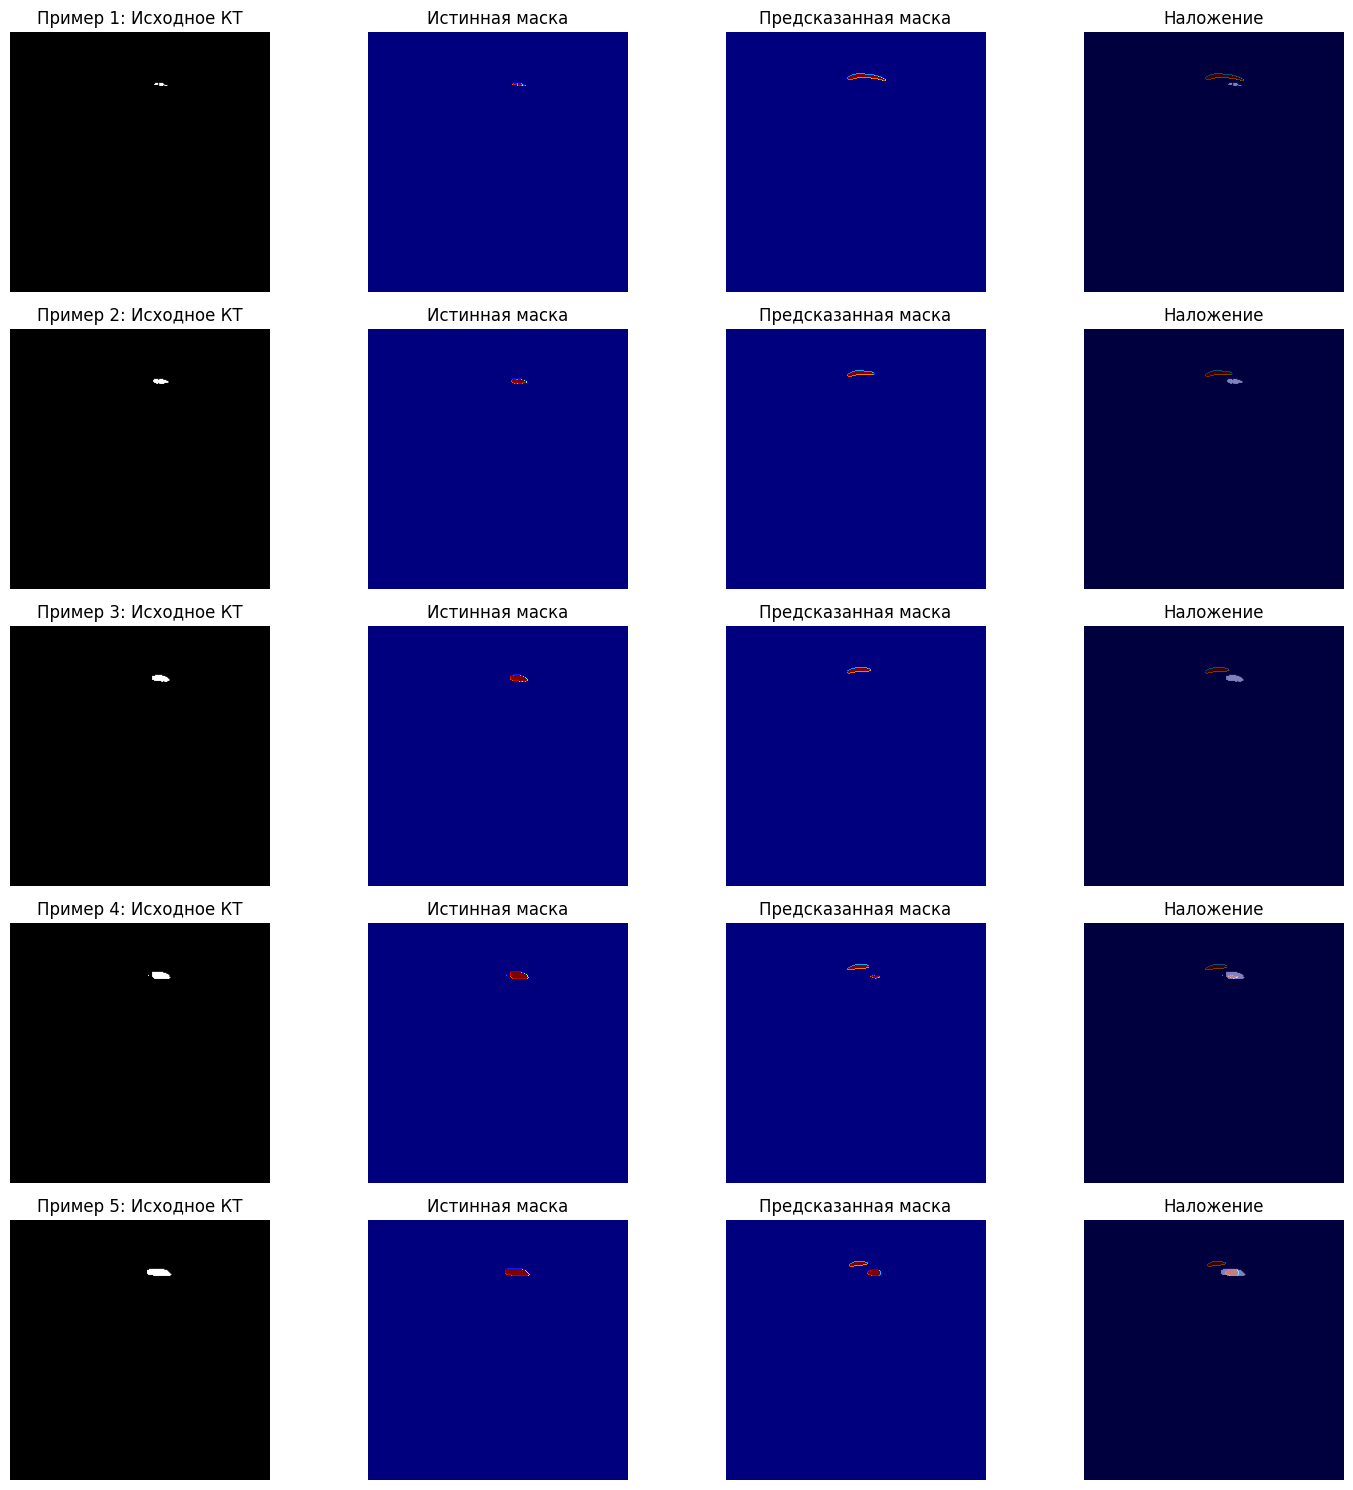

✅ Все визуализации сохранены!


In [10]:
def plot_training_history(history):
    """Визуализируем историю обучения"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice Score
    axes[0, 1].plot(history['train_dice'], label='Train Dice', linewidth=2)
    axes[0, 1].plot(history['val_dice'], label='Val Dice', linewidth=2)
    axes[0, 1].set_title('Dice Score')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[0, 2].plot(history['train_iou'], label='Train IoU', linewidth=2)
    axes[0, 2].plot(history['val_iou'], label='Val IoU', linewidth=2)
    axes[0, 2].set_title('IoU Score')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('IoU')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(history['learning_rates'], linewidth=2, color='purple')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Dice vs IoU
    axes[1, 1].plot(history['val_dice'], label='Val Dice', linewidth=2)
    axes[1, 1].plot(history['val_iou'], label='Val IoU', linewidth=2)
    axes[1, 1].set_title('Validation: Dice vs IoU')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Текстовые результаты
    axes[1, 2].axis('off')
    best_epoch = np.argmax(history['val_dice'])
    results_text = f"ЛУЧШИЕ РЕЗУЛЬТАТЫ:\n\n"
    results_text += f"Эпоха: {best_epoch + 1}\n"
    results_text += f"Dice: {history['val_dice'][best_epoch]:.4f}\n"
    results_text += f"IoU: {history['val_iou'][best_epoch]:.4f}\n"
    results_text += f"Test Dice: {test_dice:.4f}\n"
    results_text += f"Test IoU: {test_iou:.4f}"
    
    axes[1, 2].text(0.1, 0.5, results_text, fontsize=12, va='center')
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(predictions, targets, num_examples=5):
    """Визуализируем примеры предсказаний"""
    fig, axes = plt.subplots(num_examples, 4, figsize=(15, 3*num_examples))
    
    if num_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_examples, len(predictions))):
        # Исходное изображение
        img = targets[i][0, 0]  # [1, 1, H, W] -> [H, W]
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'Пример {i+1}: Исходное КТ')
        axes[i, 0].axis('off')
        
        # Истинная маска
        true_mask = targets[i][0, 0]
        axes[i, 1].imshow(true_mask, cmap='jet')
        axes[i, 1].set_title('Истинная маска')
        axes[i, 1].axis('off')
        
        # Предсказанная маска
        pred_mask = predictions[i][0, 0]
        axes[i, 2].imshow(pred_mask, cmap='jet')
        axes[i, 2].set_title('Предсказанная маска')
        axes[i, 2].axis('off')
        
        # Наложение
        axes[i, 3].imshow(img, cmap='gray')
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.5)
        axes[i, 3].set_title('Наложение')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/prediction_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Создаем визуализации
print("Создаем визуализации...")

# История обучения
plot_training_history(history)

# Примеры предсказаний
visualize_predictions(test_predictions, test_targets, num_examples=5)

print("✅ Все визуализации сохранены!")

In [11]:
def create_final_report():
    """Создаем финальный отчет"""
    print("\n" + "="*70)
    print("🎯 ФИНАЛЬНЫЙ ОТЧЕТ ОБ ОБУЧЕНИИ")
    print("="*70)
    
    print(f"\n📊 РЕЗУЛЬТАТЫ:")
    print(f"   ✅ Лучший Validation Dice: {best_dice:.4f}")
    print(f"   ✅ Test Dice:              {test_dice:.4f}")
    print(f"   ✅ Test IoU:               {test_iou:.4f}")
    
    print(f"\n⚙️  КОНФИГУРАЦИЯ ОБУЧЕНИЯ:")
    print(f"   • Optimizer:          AdamW")
    print(f"   • Learning Rate:      1e-4")
    print(f"   • Scheduler:          CosineAnnealingLR")
    print(f"   • Batch Size:         8")
    print(f"   • Эпохи:              {len(history['train_loss'])}/{EPOCHS}")
    print(f"   • Early Stopping:     {PATIENCE} эпох, min_delta={MIN_DELTA}")
    print(f"   • Loss Function:      0.6 * Dice + 0.4 * Focal")
    
    print(f"\n🎯 АУГМЕНТАЦИИ:")
    print(f"   • Сдвиги:             40% вероятность, ±10%")
    print(f"   • Повороты:           50% вероятность, ±15°")
    print(f"   • Масштабирование:    30% вероятность, 90-110%")
    
    print(f"\n📈 КАЧЕСТВО ОБУЧЕНИЯ:")
    improvement = history['val_dice'][-1] - history['val_dice'][0]
    print(f"   • Улучшение Dice:     +{improvement:.4f}")
    print(f"   • Стабильность:       {'Хорошая' if improvement > 0.1 else 'Требует настройки'}")
    
    print(f"\n💾 МОДЕЛЬ:")
    print(f"   • Архитектура:        U-Net 2D")
    print(f"   • Параметры:          {test_results['model_parameters']:,}")
    print(f"   • Input Size:         256x256")
    print(f"   • Output:             Binary mask")
    
    print(f"\n📁 ДАННЫЕ:")
    print(f"   • Всего пациентов:    {len(df_files)}")
    print(f"   • Train срезов:       {len(train_dataset)}")
    print(f"   • Val срезов:         {len(val_dataset)}")
    print(f"   • Test срезов:        {len(test_dataset)}")
    print(f"   • Preprocessing:      Liver window (150, 30)")
    
    print(f"\n🎯 РЕКОМЕНДАЦИИ:")
    if test_dice > 0.85:
        print("   • Отличный результат! Модель готова к использованию.")
    elif test_dice > 0.75:
        print("   • Хороший результат. Можно улучшить добавлением данных.")
    else:
        print("   • Требуется доработка: попробуйте другие аугментации или архитектуру.")
    
    print(f"\n📂 СОХРАНЕННЫЕ ФАЙЛЫ:")
    print("   • models/best_model.pth    - лучшая модель")
    print("   • models/final_model.pth   - финальная модель")
    print("   • results/training_history.png - графики обучения")
    print("   • results/prediction_examples.png - примеры предсказаний")
    print("   • results/test_results.json  - результаты тестирования")
    
    print("\n" + "="*70)

# Запускаем финальный отчет
create_final_report()

# Сохраняем полную информацию о обучении
final_stats = {
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'scheduler': 'CosineAnnealingLR',
        'batch_size': 8,
        'epochs': EPOCHS,
        'early_stopping': {
            'patience': PATIENCE,
            'min_delta': MIN_DELTA,
            'monitor': 'val_dice'
        },
        'loss_function': '0.6 * Dice + 0.4 * Focal',
        'augmentations': {
            'shift': {'probability': 0.4, 'max_shift': 0.1},
            'rotation': {'probability': 0.5, 'max_angle': 15},
            'scale': {'probability': 0.3, 'scale_range': [0.9, 1.1]}
        }
    },
    'final_results': {
        'best_val_dice': best_dice,
        'test_dice': test_dice,
        'test_iou': test_iou,
        'total_parameters': test_results['model_parameters'],
        'training_time_epochs': len(history['train_loss'])
    }
}

with open('results/final_statistics.json', 'w') as f:
    json.dump(final_stats, f, indent=2)

print("🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО! 🎉")


🎯 ФИНАЛЬНЫЙ ОТЧЕТ ОБ ОБУЧЕНИИ

📊 РЕЗУЛЬТАТЫ:
   ✅ Лучший Validation Dice: 0.9566
   ✅ Test Dice:              0.9149
   ✅ Test IoU:               0.8757

⚙️  КОНФИГУРАЦИЯ ОБУЧЕНИЯ:
   • Optimizer:          AdamW
   • Learning Rate:      1e-4
   • Scheduler:          CosineAnnealingLR
   • Batch Size:         8
   • Эпохи:              24/30
   • Early Stopping:     10 эпох, min_delta=0.002
   • Loss Function:      0.6 * Dice + 0.4 * Focal

🎯 АУГМЕНТАЦИИ:
   • Сдвиги:             40% вероятность, ±10%
   • Повороты:           50% вероятность, ±15°
   • Масштабирование:    30% вероятность, 90-110%

📈 КАЧЕСТВО ОБУЧЕНИЯ:
   • Улучшение Dice:     +0.0685
   • Стабильность:       Требует настройки

💾 МОДЕЛЬ:
   • Архитектура:        U-Net 2D
   • Параметры:          31,383,681
   • Input Size:         256x256
   • Output:             Binary mask

📁 ДАННЫЕ:
   • Всего пациентов:    131
   • Train срезов:       4176
   • Val срезов:         686
   • Test срезов:        2885
   • Preprocessing

Тестирование на Anon_Liver